In [1]:
import csv

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

In [2]:
def read_csv_column(col):
    with open('./sentiment_stem.txt') as file:
        reader = csv.reader(file, delimiter='\t')
        header = next(reader)
        return [row[col] for row in reader]    

In [3]:
x_all = read_csv_column(1)
y_all = read_csv_column(0)

In [4]:
cv = CountVectorizer(min_df=0.0005, max_df=0.10)
# cv = CountVectorizer()

In [5]:
x_all_cv = cv.fit_transform(x_all)
x_train, x_test, y_train, y_test = train_test_split(x_all_cv, y_all)

In [6]:
lr = LogisticRegression()
#lr = LogisticRegression(solver='sag', max_iter=10000, verbose=2)

In [7]:
tuned_parameters = [
    {'C': [1, 1.5, 2, 2.5], 'solver': ['newton-cg']},
    {'C': [1, 1.5, 2, 2.5], 'solver': ['lbfgs']},
    {'C': [1, 1.5, 2, 2.5], 'solver': ['liblinear'], 'penalty':['l1', 'l2']},
    {'C': [1, 1.5, 2, 2.5], 'solver': ['sag']},
    {'C': [1, 1.5, 2, 2.5], 'solver': ['saga']}
    ]

#    {'C': [1, 10, 100], 'solver': ['newton-cg']},
#    {'C': [1, 10, 100], 'solver': ['lbfgs']},
#    {'C': [1, 10, 100], 'solver': ['liblinear'], 'penalty':['l1', 'l2']},
#    {'C': [1, 10, 100], 'solver': ['sag']},
#    {'C': [1, 10, 100], 'solver': ['saga']}


In [8]:
score = 'f1'
clf = GridSearchCV(
    lr, # 識別器
    tuned_parameters, # 最適化したいパラメータセット 
    cv=5, # 交差検定の回数
    scoring='%s_weighted' % score ) # モデルの評価関数の指定

In [9]:
%%time
clf.fit(x_train, y_train)

/home/i348221/Apps/python/venv/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 31 s, sys: 413 ms, total: 31.4 s
Wall time: 33 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 1.5, 2, 2.5], 'solver': ['newton-cg']},
                         {'C': [1, 1.5, 2, 2.5], 'solver': ['lbfgs']},
                         {'C': [1, 1.5, 2, 2.5], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [1, 1.5, 2, 2.5], 'solver': ['sag']},
  

In [10]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'solver': 'lbfgs'}
0.7260922573632175


In [11]:
# スコアの一覧を取得
gs_result = pd.DataFrame.from_dict(clf.cv_results_)
gs_result.to_csv('gs_result.csv')

In [12]:
len(cv.get_feature_names())

3143

In [13]:
# 最高性能のモデルを取得し、テストデータを分類
best = clf.best_estimator_
y_pred = best.predict(x_test)
best.score(x_test, y_test)

0.7505626406601651

In [14]:
best.score(x_train, y_train)

0.8833166583291646

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1340
           1       0.75      0.75      0.75      1326

    accuracy                           0.75      2666
   macro avg       0.75      0.75      0.75      2666
weighted avg       0.75      0.75      0.75      2666



In [16]:
print(confusion_matrix(y_test, y_pred))

[[1005  335]
 [ 330  996]]


In [17]:
%%time
training_sizes, train_scores, test_scores = learning_curve(best,
                                                x_all_cv, y_all, cv=10,
                                                scoring='%s_weighted' % score,
                                                train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

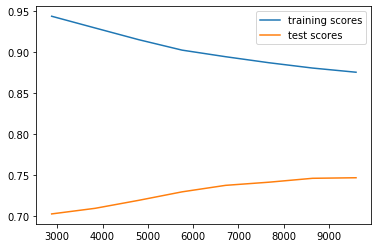

In [18]:
plt.plot(training_sizes, train_scores.mean(axis=1), label="training scores")
plt.plot(training_sizes, test_scores.mean(axis=1), label="test scores")
plt.legend(loc="best")

In [19]:
y_pred = best.predict_proba(x_test)
print(y_pred.shape)
print(y_pred[:,1])

(2666, 2)
[0.84468552 0.78875972 0.10130827 ... 0.98422918 0.2647371  0.09418938]


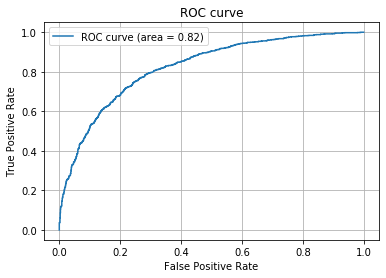

In [20]:
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1], pos_label='1')

# ついでにAUCも
auc = auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [21]:
# ある閾値の時の適合率、再現率, 閾値の値を取得
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred[:,1], pos_label='1')

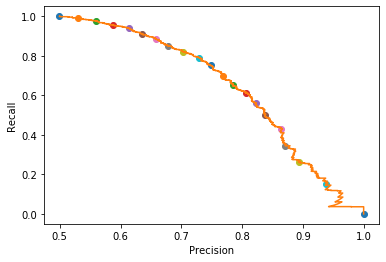

In [22]:
# 0から1まで0.05刻みで○をプロット
for i in range(21):
    close_point = np.argmin(np.abs(thresholds - (i * 0.05)))
    plt.plot(precisions[close_point], recalls[close_point], 'o')
# 適合率-再現率曲線
plt.plot(precisions, recalls)
plt.xlabel('Precision')
plt.ylabel('Recall')
 
plt.show()